<a href="https://colab.research.google.com/github/hariszaf/coi_dark_matter/blob/master/dark_matter_on_coi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dark matter on COI marker gene Project

## Pipeline

* Get as many as possible COI sequences from all the 3 domains of life
* Keep consensus sequences for each domain conserving as much diversity of those as possible
* Build a single tree for all the consensus sequences
* Assign query sequences from in-house data in the reference tree 

## For this ```.ipynb```

This is a Google Colab document; In fact, it's a Jupyter notebook environment that requires no setup to use and runs entirely in the cloud.

Python scripts can be implemented on this document. Let's see an example. Just press the **play** button next to the following block of code. 

In [ ]:
print("Hello friend")

Hello friend


This environment, cannot run any languages though. So as we have quite a few blocks of code in ```bash``` you need to be careful as they **will not be performed** on our doc; you will have to copy - paste them on your environment if you would like to see what they are doing exactly. As an example, if you try to **play** the next block of code, you will get an error

In [ ]:
echo "hello friend"

To avoid any misunderstandings on the code, in the third line of every block of code, there will be either the 
```
 #!/usr/bin/python3.5
```  
statement, pointing out that this is a Python scirpt, or the 
```
 #!/usr/bin/bash
```
for those that are bash scripts. The python version does not really matter as long as it is Python 3. 

 

Furthermore, you will see some scripts including on their top lines like this:
```
#!/bin/bash

#SBATCH --partition=batch
#SBATCH --nodes=1
#SBATCH --nodelist=
#SBATCH --ntasks-per-node=20
```

These are the scripts that we ran as jobs on the Zorba cluster; we will call them *sbatch* files. I have these ```#SBATCH``` lines as they are **rather important** especially in case we need parallel computing architectures.

You are able to comment, write or remove anything you want. However, as the history of this type of documents is not that reliable for the time being, please if you change something leave a clear message what was it and the reason you changed it! 

Keep in mind that you are able to get this document as a ```.pdf``` file any time you want in a straight-forward way. You just need to ```File --> Print --> Save as PDF``` and that's it.

We can now move to our dark matter investigation! 

**Important note**

I will try to build a GitHub repositoty as soon as possible, and get all the scripts there. **However**, it is rather hard to include individual commands in a repo. Thus, this ```.ipynb``` file will be also incuded in the repo. You can do that by just clicking ```File --> Save a copy in GitHub```.

## Data & Methods

To build our reference tree, we use sequences of the COI marker gene from the 3 domains of life (Eukaryotes, Bacteria and Archaea). We collected these sequences from [MIDORI](http://reference-midori.info/index.html) database for the Eukaryotes and from the NCBI for Bacteria and Archaea. 

To get the corresponding sequences for Bacteria and Archaea we run the following block of code. 

### Bacteria

In [ ]:
## Script No 1 : get_webenv.py

#!/usr/bin/python3.5

# Bacteria
import requests
import re

db = "nucleotide"

# In the following query we describe what sequences we need to get. Filters allow to get exactly what we need from the NCBI database
query = "Coi[All Fields] OR Cytochrome c oxidase subunit I[All+Fields] OR CO1[All Fields] AND (Bacteria[Organism] OR Bacteria Latreille+et+al. 1825[Organism]) AND (1[SLEN]:2000[SLEN])) AND (bacteria[filter])"

# Get the WebEnv code - this is different every time you run this; thus we keep in a text file and then feed it accordingly in a next command
base = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
url = base + "esearch.fcgi?db=" + db + "&term=" + query + "&usehistory=y"
response = requests.get(url)

print(response.text)

#f = open("response_file.xml","w+")           # In the response_file.xml file, you may find the EnvWev value returned from the query we asked 
#f.write(response.text)
#f.close()


After getting the ```WebEnv``` key. We are able to run the following piece of code that will actually return the sequences we asked for. 

In [ ]:
## Script No 2: download_sequences.py

#!/usr/bin/python3.5

# As you can see, in the end of the query there is a value for the WebEnv parameter; this needs to change accordingly with the output of the previous piece of code
# You need to check the response_file.xml to get the WebEnv value returned and add it to the url query
webenv = "MCID_5f45715d8e3d0d1989309a0d"
url_prefix = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=nucleotide&query_key=1&WebEnv="
url_suffix = "&rettype=fasta"
url = url_prefix + webenv + url_suffix

# Get the url 
# This is a quite long query and in case you run it, be aware that it will take some time! 
seqs = requests.get(url)

## Keep the sequences to a file 
#h = open("bacteria_sequences.fasta","w+")
#h.write(seqs.text)
#h.close()


Now in the ```bacteria_sequences.fasta``` file you can find our sequences. Here is the first one, as an example:

```
>MT634227.1 Wolbachia pipientis strain PY_KM2017 cytochrome c oxidase subunit I (coxA) gene, partial cds
TCACTATATTTAATATGCGTGCAAAAGGCATGTCATTGACCAAGATGCCACTATTTGTTTGGTCTGTTTT
ATTAACGTCGTTTATGTTAATTGTTGCCTTACCGGTACTTGCTGGTGCTATAACTATGCTGCTAACTGAT
CGTAATATAGGTACTTCCTTTTTTGATCCTGCTGGTGGCGGTGATCCTGTGTTATTTCAACACCTGTTTT
GGTTTTTTGGTCATCCAGAAGTTTACATAATTATTTTTCCTGCATTTGGCATCATAAGCCAAGTCGTATC
AACTTTTTCCCATAGGCCAGTATTTGGCTATAAAGGAATGGTTTATGCAATGATAGGCATAGCAGCATTT
GGCTTTATGGTTTGGGCTCACCATATGTTTACTGTTGGGCTTAGCGAAGATGCTGCTATATTTTTTAGCA
CTACAACAATTTTTATTGGCGTTATA
```

As you can see, there is no taxonomy for the sequence, only the species name. So, the next step is to get the full taxonomy for each sequence. 

To this end, we first need to get the corresponding NCBI Taxonomy Ids to the sequences we got. 

Thus we will now use another Entrez command (to get the sequences we used ```efetch``` as you can see in the url in the previous block of code). Using the ```esummary``` command we can get all the information related to our queries. 

In [ ]:
## Script No 3: download_summaries.py

#!/usr/bin/python3.5

import requests

# You need to check the response_file.xml to get the WebEnv value returned and add it to the url query. As we did for the download_sequences.py
webenv = "MCID_5f458093dc1d7a5897749052"
url_prefix = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=nucleotide&query_key=1&WebEnv="
url_suffix = "&version=2.0"
url = url_prefix + webenv + url_suffix

# Get the url 
metadata = requests.get(url)

# # Create a file and keep the sequences retrieved
# h = open("bacteria_summaries.fasta","w+")
# h.write(metadata.text)
# h.close()


And here is the top of the ```bacteria_summaries.txt``` file we just built. 
```
<?xml version="1.0" encoding="UTF-8" ?>
<!DOCTYPE eSummaryResult PUBLIC "-//NLM//DTD esummary nuccore 20190808//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20190808/esummary_nuccore.dtd">
<eSummaryResult>
<DocumentSummarySet status="OK">
<DocumentSummary uid="1890528706">
	<Caption>MT634227</Caption>
	<Title>Wolbachia pipientis strain PY_KM2017 cytochrome c oxidase subunit I (coxA) gene, partial cds</Title>
	<Extra>gi|1890528706|gb|MT634227.1|</Extra>
	<Gi>1890528706</Gi>
	<CreateDate>2020/08/19</CreateDate>
	<UpdateDate>2020/08/19</UpdateDate>
	<Flags>0</Flags>
	<TaxId>955</TaxId>
	<Slen>446</Slen>
```

In the Title label it is mentioned that this sequence is coming from a *Wolbachia pipientis strain*.

As you can see, there is also a label called ```TaxId```. That is the NCBI Taxonomy Id for the species from which this sequence is coming from. 

So now, if you visit the [NCBI Taxonomy Id database]() and make a query for the Id 955 [here](https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi) is what you will get. 
The 955 hits the *Wolbachia pipientis*.

Now, we do have a NCBI Id, but this is not a taxonomy. To get this, we will use the [FTP: NCBI Taxonomy](https://ftp.ncbi.nlm.nih.gov/pub/taxonomy/) and more specifically the ```new_taxdump.tar.gz``` tarball. In this, as you may see in its corresponding [```taxdump_readme.txt```](https://ftp.ncbi.nlm.nih.gov/pub/taxonomy/new_taxdump/taxdump_readme.txt) file, there is the ```fullnamelineage.dmp``` file, where the complete lineage of each NCBI Taxonomy Id can be found. 

So, after downloading this file on Zorba, we are now able to make a match between the TaxId of each sequence we got and its corresponding lineage. 

We should mention here, that the sequences and the summaries retrieved follow the same order, i.e the first sequence is the ```>MT634227.1 Wolbachia pipientis strain PY_KM2017 cytochrome c oxidase subunit I (coxA) gene, partial cds``` and the first summary is its corresponding:
```	
<Caption>MT634227</Caption>
<Title>Wolbachia pipientis strain PY_KM2017 cytochrome c oxidase subunit I (coxA) gene, partial cds</Title>
....
```

And here is the code for this part:

In [ ]:
## Script No 4: match_taxonomies.sh

#!/usr/bin/bash

# First, we keep all the TaxIds from the bacteria_summaries.xml file, by making use of a grep command 
grep "TaxId" bacteria_summaries.xml | sed -e 's/<TaxId>//g ; s/<\/TaxId>//g ; s/\t//g' > tax_ids.tsv

# Likewise, for the caption of the summaries
grep "Caption" bacteria_summaries.xml | sed -e 's/<Caption>//g ; s/<\/Caption>//g ; s/\t//g' > captions_included_in_summaries.tsv

# Now, we need to merge those two files in a 2-column file which will be like this: 
# MT634227	955
# NZ_RXLZ01000172	40324
# (the caption of the sequence in the first and the NCBI Taxonomy Id in the second column)
paste captions_included_in_summaries.tsv tax_ids_included_in_summaries.tsv > caption_taxid_in_summaries.tsv

# And you may remove the previous intermidate files captions_included_in_summaries.tsv and tax_ids_included_in_summaries.tsv
rm captions_included_in_summaries.tsv tax_ids_included_in_summaries.tsv


Now we can write a Python script that will read the ```tax_ids_included_in_summaries.tsv``` file and for the TaxId in each line will find the corresponding taxonomy from the ```fullnamelineage.dmp``` file. As already mentioned, we could have these file on the Drive, however it is not suggested to do so in this case. If you would like to run this you just need to get the input files to your computational environment and replace the paths. I am trying to use as few as possible dependencies. If you do run it, keep in mind that it will take some time! We parse all the taxonomies of NCBI if you consider it! ;) 

In [ ]:
## Script No 5: match_taxid_to_taxonomy.py 

#!/usr/bin/python3.5

import io

# Important note! 
# The fullnamelineage.dmp we are about to use is a non-ascii file; thus we need to remember forcing for the utf-8 encoding


# Files we need
parent_directory = "/home1/haris/Desktop/stsm/sequences_of_life/bacteria"
ncbi_taxonomy_fullname_file = parent_directory + "/ncbi_taxonomy/fullnamelineage.dmp"
caption_taxids_in_summaries_file = parent_directory + "/caption_taxid_in_summaries.tsv"


# Build a dictionary with the information included in the fullnamelineage.dmp file in a way that suits for our case

dict_ncbi_tax_id_full_taxonomy = {}

with io.open(ncbi_taxonomy_fullname_file, mode="r", encoding="utf-8") as tax_file:

    for entry in tax_file:


        elements = entry.split("\t")

        ncbi_tax_id = elements[0]
        species_name = elements[2]
        lineage = elements[4]

        # Process these elements to convert them in a format that suits to the needs of our study; see further on the text
        lineage = lineage.replace('cellular organisms; ','')
        lineage = lineage.replace('; ',';')
        lineage = lineage.replace(' ','_')

        species_name = species_name.replace(' ','_')

        # Build the full taxonomy of the species
        taxonomy = lineage + species_name

        # Keep this info in the corresponding dictiontary
        dict_ncbi_tax_id_full_taxonomy[ncbi_tax_id] = taxonomy

# Parse the file with both the caption and their corresponding TaxIds and add a column with the full taxonomy they match 
# using the NCBI TaxId to do the matching
with open(caption_taxids_in_summaries_file) as f:

    our_taxa = {}

    for entry in f:

        elements = entry.split("\t")

        # As there is a new line character added in the ncbi id we have not to keep it
        entry_ncbi_id = elements[1][:-1]
        entry_caption = elements[0]
        our_taxa[entry_caption] = entry_ncbi_id

    # Parse the dictionary we built from the fullnamelineage.dmp file
    for ncbi_id, taxonomy in dict_ncbi_tax_id_full_taxonomy.items():

        # And check whether the ncbi id we have mathes with one from our taxa
        for caption, entry_ncbi_id in our_taxa.items():

            if ncbi_id == entry_ncbi_id:

                new_line = caption + "\t" + ncbi_id + "\t" + taxonomy + "\n"
                with open("caption_taxid_taxonomy.tsv", 'a+') as output:
                    output.write(new_line)
                    output.close()


Now we are quite happy! Let's have a look in the last file we built, called ```caption_taxid_taxonomies.tsv```.

```
MG987635	2488906	Bacteria;Proteobacteria;Alphaproteobacteria;Rickettsiales;Anaplasmataceae;Wolbachieae;Wolbachia;unclassified_Wolbachia;Wolbachia_endosymbiont_of_Chrysolina_herbacea
LR798864	2736843	Bacteria;Proteobacteria;Alphaproteobacteria;Rickettsiales;Rickettsiaceae;Rickettsieae;Rickettsia;unclassified_Rickettsia;Rickettsia_endosymbiont_of_Hemiptera_sp.
```
As you can see it is a 3 column file, having the caption of each of the sequences retrieved in the first column, its corresponding NCBI Id in the second and its full taxonomy in the third one. Notice the format of the taxonomy. It is rather important for our next steps.


As in Biology, we are far away from best practices, our queries in NCBI is almost sure that will return things we would not like to and loose some others that we would like to have. For the latter we cannot do much, but we can remove the first ones. In our study we have an *incredible* example of such. **Semi-automated** overview of our dataset allowed us to find this phenomenon entry: [*Uncultured bacterium clone CO1 16S ribosomal RNA gene, partial sequence*](https://www.ncbi.nlm.nih.gov/nuccore/GU946143.1). Obviously this is a Bacterial sequence but not from the COI marker gene.. We need to get such cases and remove them; commands like the following allow us to get at least most of them

In [ ]:
 more bacteria_sequences.fasta | grep ">" | grep 16S | sed 's/>//g ; s/\.1//g' | awk -F " " '{print $1}' > non_coi_captions.tsv

So, now we can change our sequence file accordingly, by replacing their title with the corresponding taxonomy, using the caption field. To do this we run a small Python script 

In [ ]:
## Script No 6: build_seq_with_taxonomies.py

#!/usr/bin/python3.5

bacteria_path = "/home1/haris/Desktop/stsm/sequences_of_life/bacteria"
sequences_file = bacteria_path + "/bacteria_sequences.fasta"
caption_taxid_taxonomy_file = bacteria_path + "/caption_taxid_taxonomy.tsv"
output_file = bacteria_path + "/bacteria_sequences_taxonomy.fasta"
banned_captions = bacteria_path + "/non_coi_captions.tsv"

# Open the file with the sequences retrieved
with open(sequences_file, 'r') as seq_file:
    
    # And the 3 - column file
    with open(caption_taxid_taxonomy_file, 'r') as tax_file:
 
        # Build a dictionary with caption : taxonomy pairs    
        caption_taxonomy = {}
        for line in tax_file:
            line = line.split("\t")
            caption = line[0]
            taxonomy = line[2]            
            caption_taxonomy[caption] = taxonomy

        tax_file.close()

        # Open the output file 
        with open(output_file, "w+") as output:

            # And the file with the non COI sequences' captions; keep those in a list  
            with open(banned_captions, "r") as banned:
                banned_captions = []
                for entry in banned:
                    banned_captions.append(entry[:-1])
                banned.close()
                
            # Parse the sequence file to match
            checking_var = 1
            for line in seq_file:
                
                if line[0] == ">" :
                    
                    checking_var = 1
                    line = line.split(" ")
                    caption = line[0][1:-2]
                    
                    # Check if the caption of the study is among the banned ones
                    if caption not in banned_captions:

                        new_line = ">" + caption + " " + caption_taxonomy[caption]
                        output.write(new_line)

                    # If it is change the checking_var to 0; this will allow us not to print the sequence lines of this entry to the new file. 
                    else:
                        checking_var = 0

                else:
                    
                    if checking_var == 1:
                        output.write(line)
                    else:
                        continue
seq_file.close()
output.close()


Now we are (almost) ready for the **[PhAT](https://academic.oup.com/bioinformatics/article/35/7/1151/5088318)** algorithm!

Before that though, let's see what exactly this step is for. 
The sequences we got from NCBI which are *supposed* to be from COI of Bacteria are 6.891. If we keep this number of sequences and add to this the number of COI sequences for Eukaryotes that we are about to get in the next step, we will have a huge number of sequences; in this case a phylogeny tree will be almost both impossible to implement and rather hard to comprehend. 

Thus, we need to reduce the number of sequences, keeping somehow as diversity as possible; i.e building consensus sequences. 

The PhAT algorithm makes use of the entropy of the sequences and help us on that. However, we said almost ready because the PhAT algorithm needs a MSA (Multiple Sequence Alignment) to run. Thus, first we need to run [```mafft```](https://mafft.cbrc.jp/alignment/software/algorithms/algorithms.html), a great algorithm for alignment. 

Here is the first sbatch file of our pipeline. 


In [ ]:
## Script No 7.1: mafft_job.sh

#!/bin/bash

#SBATCH --partition=batch
#SBATCH --nodes=1
#SBATCH --nodelist=
#SBATCH --ntasks-per-node=20
#SBATCH --mem=
# Memory per node specification is in MB. It is optional.
# The default limit is 3000MB per core.
#SBATCH --job-name="bact-mafft"
#SBATCH --output=bacteria_mafft.output
#SBATCH --mail-user=haris.zafr@gmail.com
#SBATCH --mail-type=ALL
#SBATCH --requeue

/usr/bin/mafft --thread 20 --globalpair bacteria_sequences_taxonomy.fasta > aligned_bacteria_sequences.fasta


That is what we did in the first place. However, as Chistina pointed out, we had to deal with a quite important issue; as NCBI neither has a certain policy for including plus or minus sequences, nor says somewhere whether a sequence is one or the other, we have a dataset that most likely includes both. That is bad news for an alignment. So, after reading almost everything about the ```mafft``` tool, we found out about [this](https://mafft.cbrc.jp/alignment/software/adjustdirection.html?fbclid=IwAR0pM2hzZZiCBhdcOJkZP9MmZfPNvnDrPVyDC-OdRfhkEWAGyLl8sJYNbzI) super feauture! 

So, as these lines are put together, we are running a second alignment for the Bacteria COI sequences with the following sbatch script.

In [ ]:
## Script No 7.2: mafft_job_orientation.sh

#!/bin/bash

#SBATCH -N 2
#SBATCH -B 2:10:1
#SBATCH --partition=batch

#SBATCH --ntasks-per-node=15
#SBATCH --cpus-per-task=1
#SBATCH --hint=compute_bound
#SBATCH --job-name="orient"

#SBATCH --output=bacteria_mafft_orient.output
#SBATCH --mail-user=haris.zafr@gmail.com
#SBATCH --mail-type=ALL
#SBATCH --requeue


export MAFFT_N_THREADS_PER_PROCESS="1"
export MAFFT_MPIRUN="/usr/bin/mpirun -n 30 -npernode 15 -bind-to none"

/mnt/big/Tools/mafft-7.453-with-extensions/bin/mafft --mpi --thread 15 --globalpair --adjustdirectionaccurately \
bacteria_sequences_taxonomy.fasta > aligned_bacteria_sequences_true_orientation.fasta


So let us have a look to our two alignments.
First, in the one that does **not** take into account the orientation. 

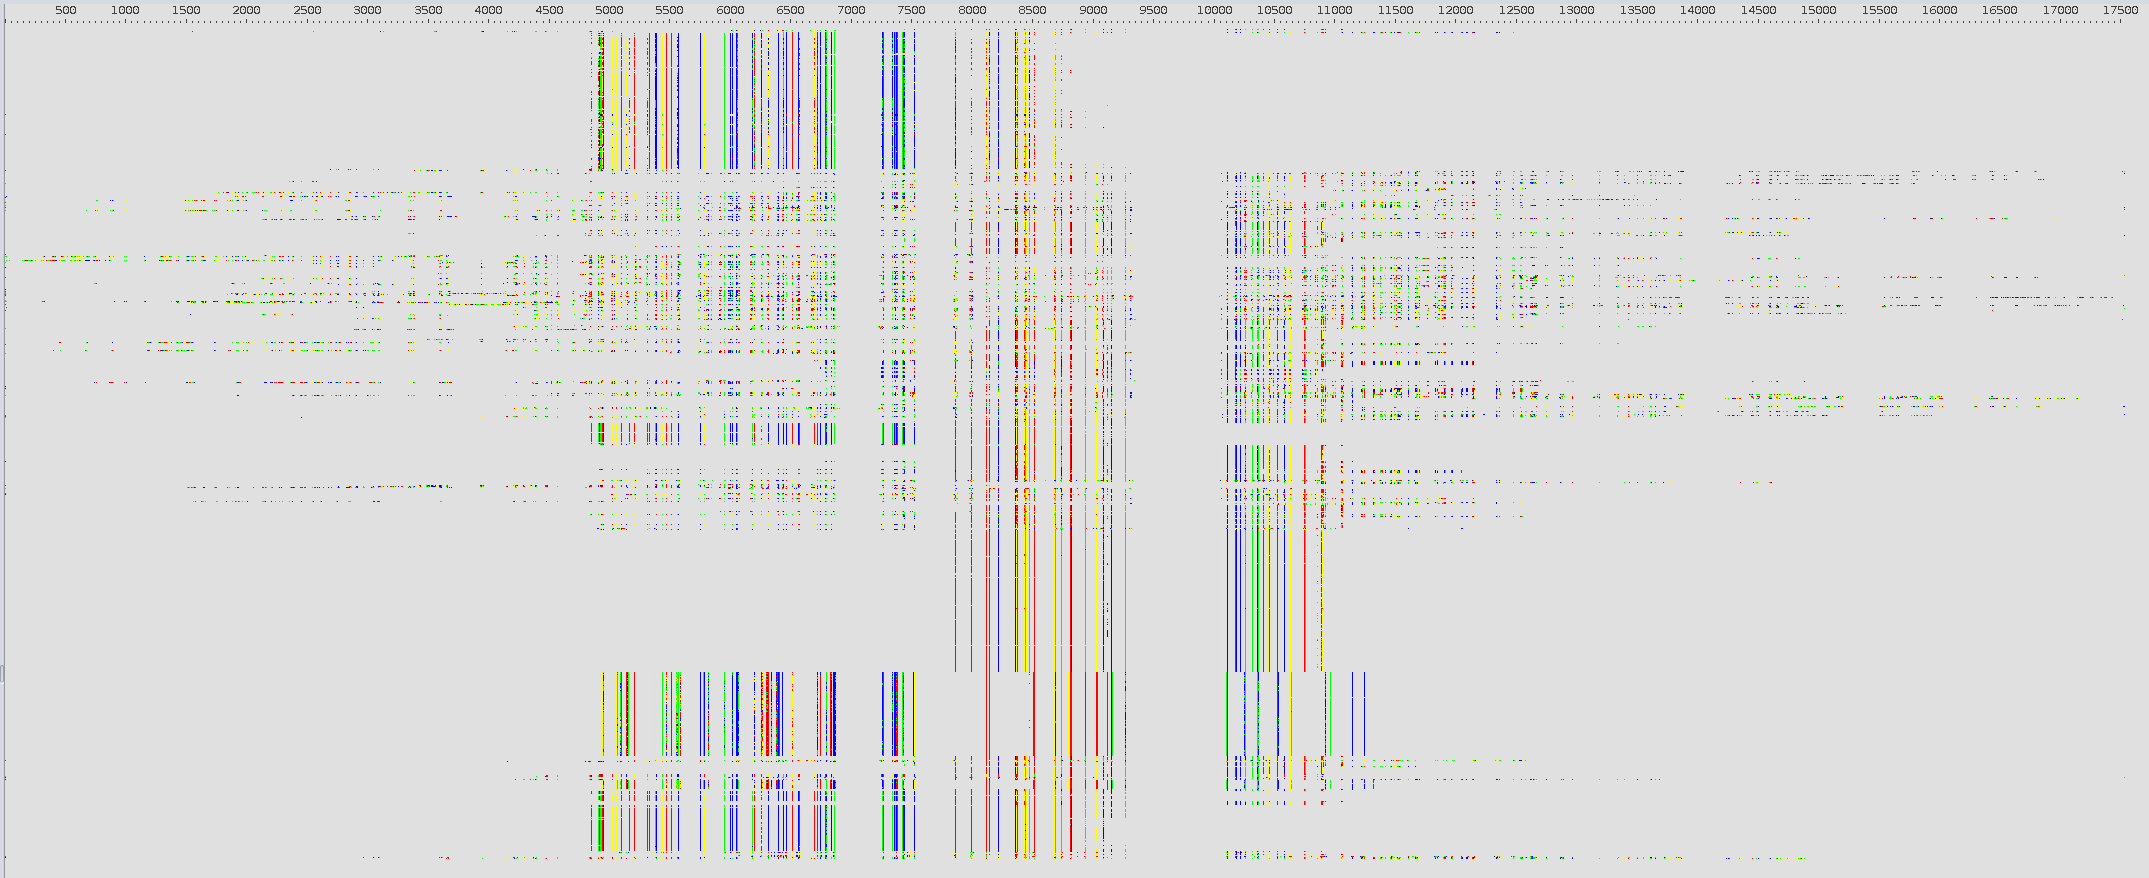

And now, on the one that derives from the mafft run with the ```--adjustdirectionaccurately``` parameter.

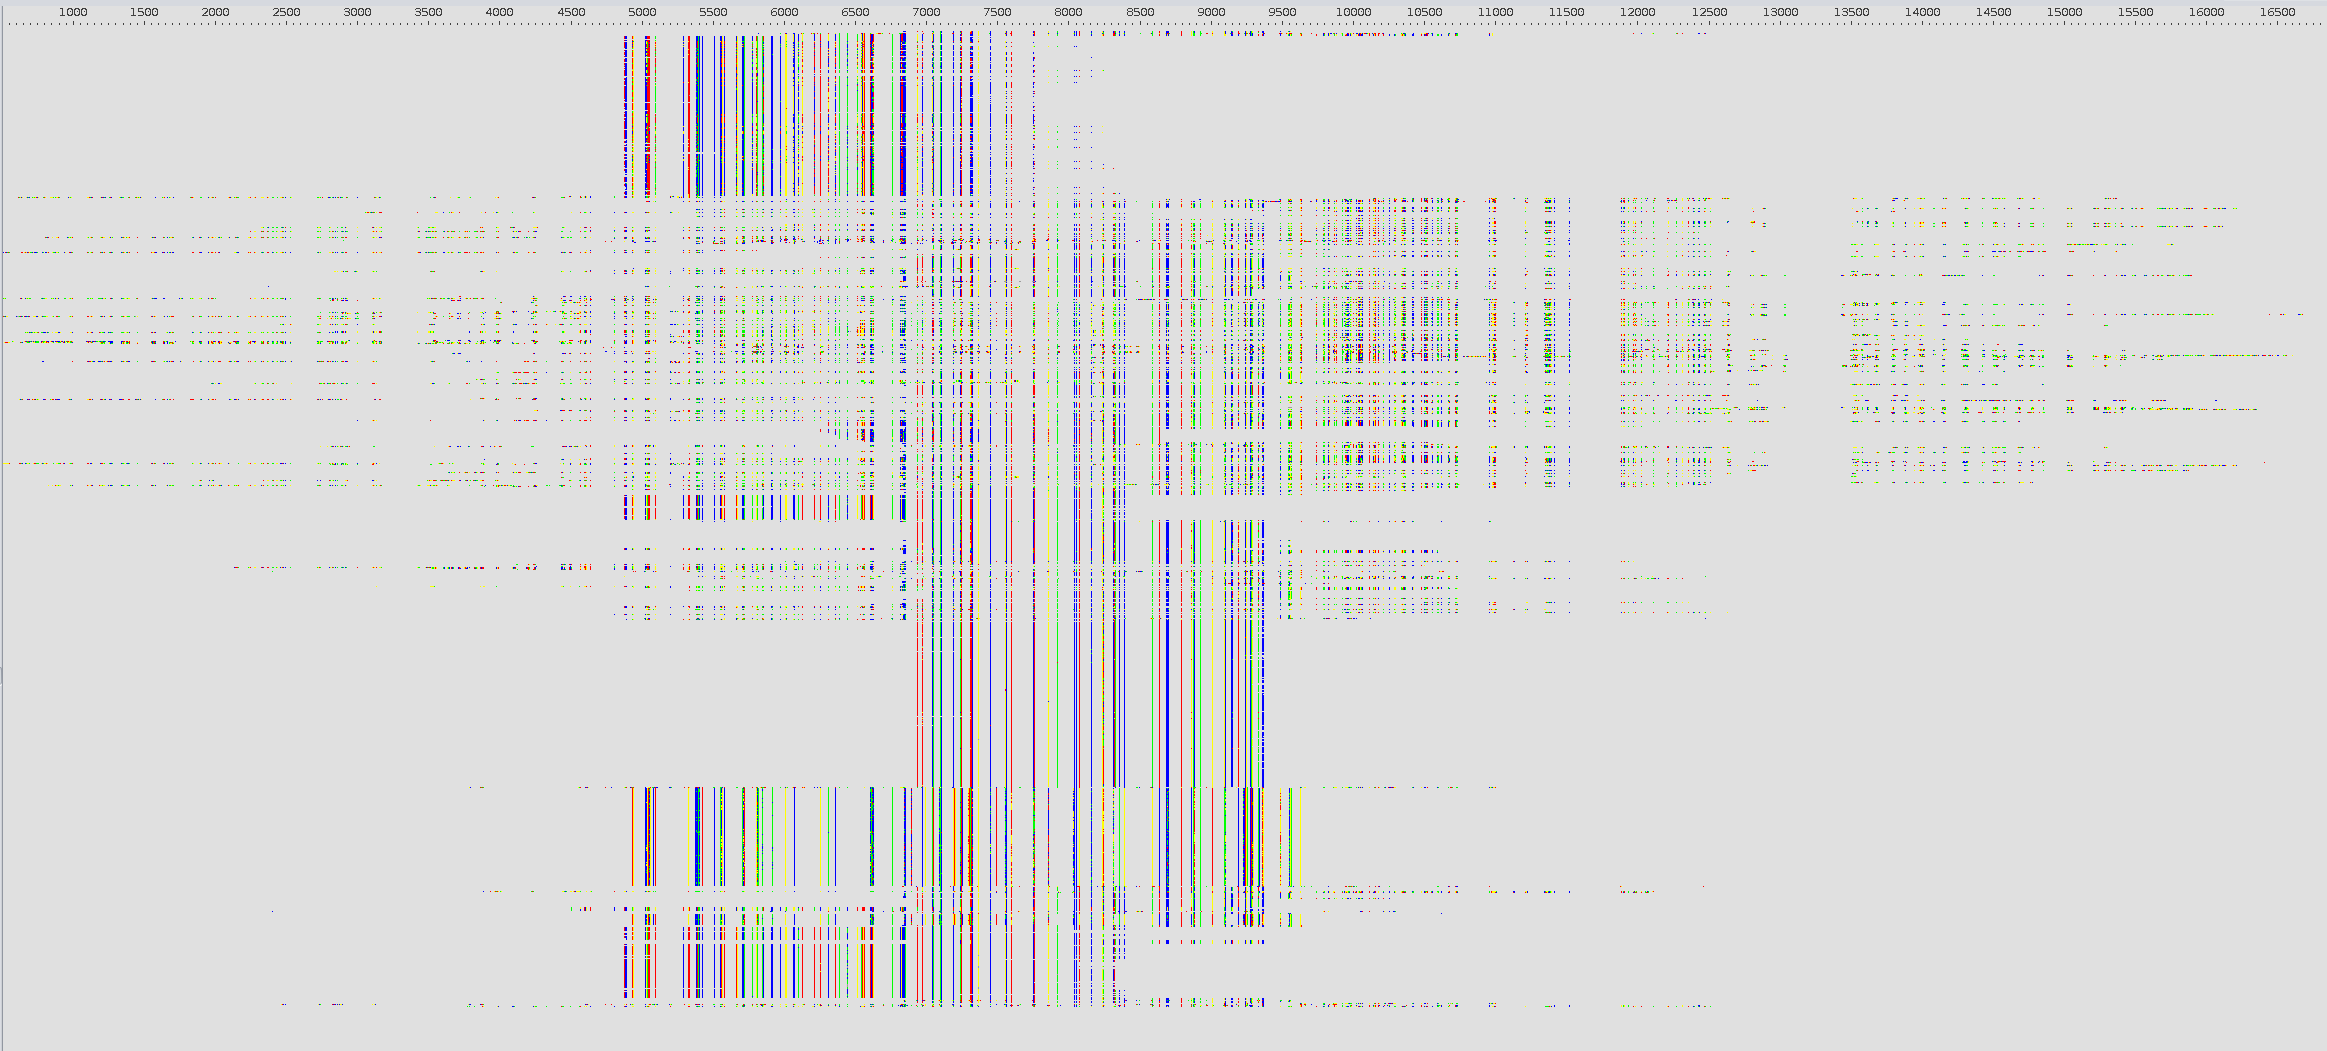

As you can see, in the second figure, we have a better (not perfect as it would not be possible for multiple reasons) result. It is my belief that we should use this alignment for our next steps; I do not have a great experience on this so any feedback would be more than welcome! :) 

Once the alignment is complete, we are finally ready to run the Phat algorithm. 
To do so, we need two input files, the alignmnet we built and another one including just the taxonomies of the species included in our MSA. To get this file is quite easy thanks to an ```awk``` command.  

In [ ]:
more aligned_bacteria_sequences_true_orientation.fasta | grep ">" | awk -F " " '{print $2}' > taxonomies_for_phat.tsv

Now that we have both the input files needed, we may (finally!) run the PhAT alogithm! 

As we discussed with Laura, we are about to use the **order** level for Eukaryotes to build our consensus sequences. So, I think that it is better to follow this in the case of Bacteria as well. However, please if you have any thoughts on that, share it **before running our trees**.

To do this trick, we use the ```--min-tax-level``` parameter. You may find more about this on its [GitHub repo](https://github.com/lczech/gappa/wiki/Subcommand:-phat).

Here is the sbatch file to run the phat algorithm - this step is very fast so you may run it even in a personal computer.


In [ ]:
## Script No 9: phat_job.sh 

#!/bin/bash

#SBATCH --partition=batch
#SBATCH --nodes=1
#SBATCH --nodelist=
#SBATCH --ntasks-per-node=20
#SBATCH --mem=
# Memory per node specification is in MB. It is optional.
# The default limit is 3000MB per core.
#SBATCH --job-name="phat"
#SBATCH --output=phat.output
#SBATCH --mail-user=haris.zafr@gmail.com
#SBATCH --mail-type=ALL
#SBATCH --requeue


/home1/haris/Desktop/stsm/sequences_of_life/gappa/bin/gappa prepare phat --taxonomy-file taxonomies_for_phat.tsv \
--sequence-file aligned_bacteria_sequences_true_orientation.fasta \
--target-size 100 \
--min-tax-level 3 \
--out-dir /home1/haris/Desktop/stsm/sequences_of_life/bacteria/phat_output

The number of different orders in our Bacteria sequences are about 68.
We ran the previous script, with multiple values of ```--target-size``` to "investigate" how the algorithm corresponds. 

So, when we asked for ```--target-size``` equal to 50 and ```--min-tax-level``` 3, then it returned 68 consensus sequences; exactly one consensus for each order, ignoring actually the 50 sequnces asked. 

Finally, in terms of having at least a 10% of bacterial sequences in our final, unified dataset (the one including both Bacteria, Euakryotes and Archaea) we asked PhAT for ```--target-size``` 100 and ```min-tax-level``` 3; PhAT returned 99 consensus sequences which we will use for our next steps. 

**Important note**

Our initial bacterial sequences are ~7.000. However, the number of different species including in those is rather small. 

## Eukaryotes

The MIDORI sequences

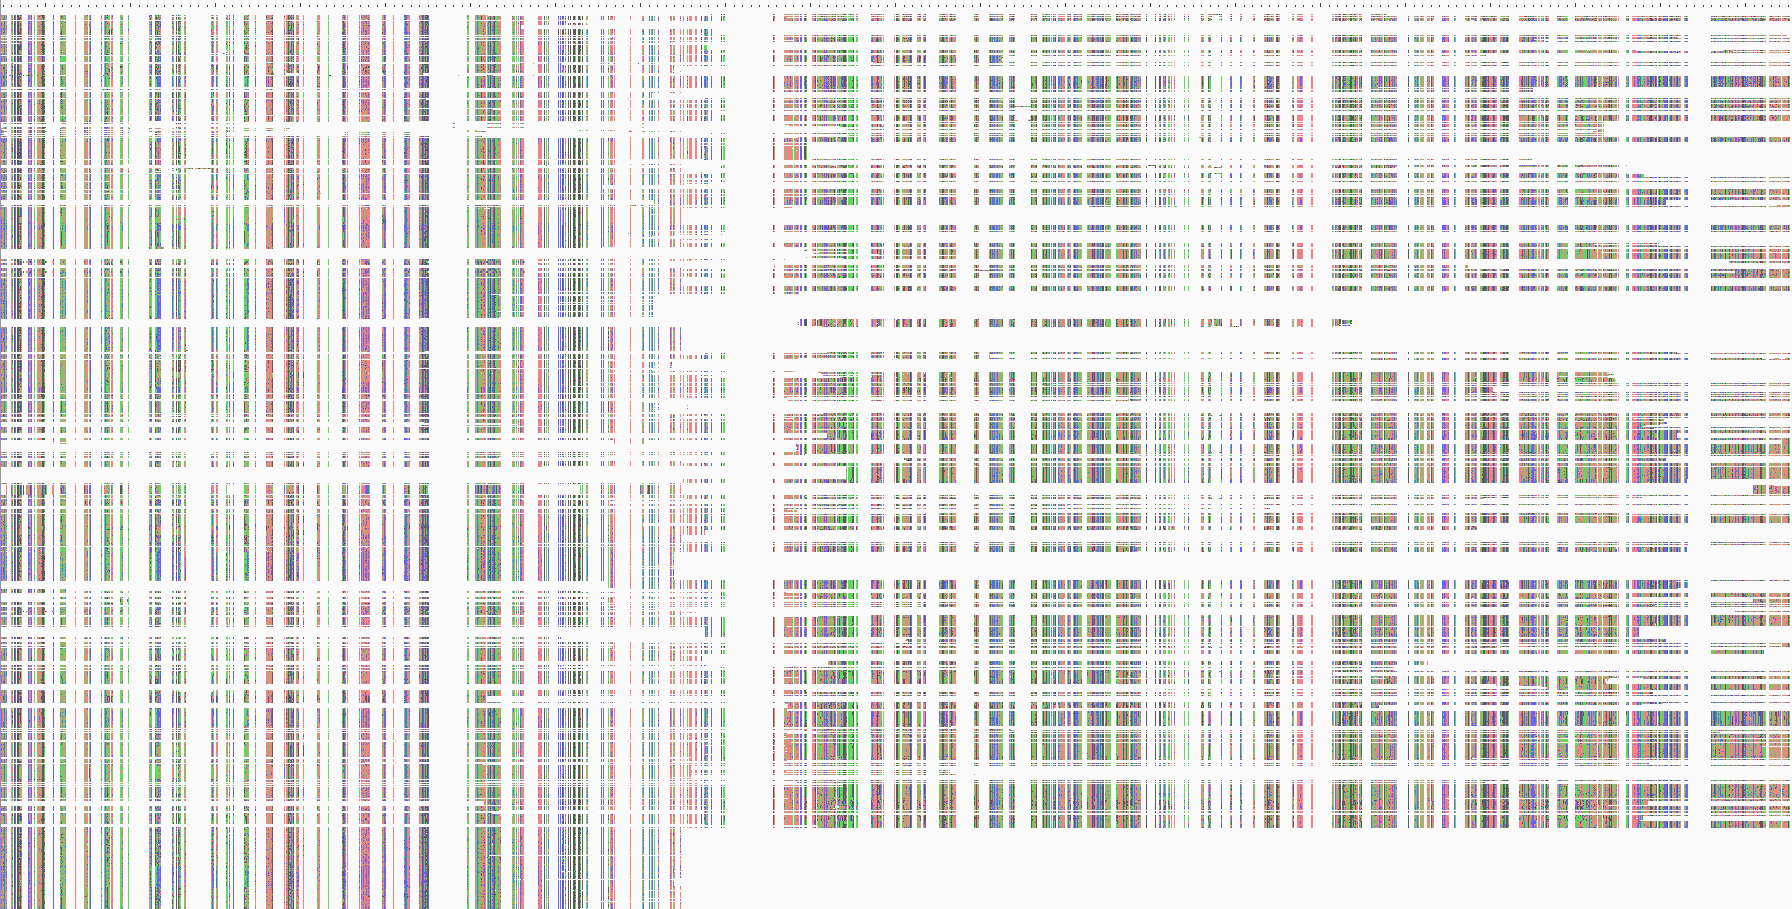